# TP 5 Réseaux de neurones - Multi classification et Propagation en avant
Dans ce TP, nous aimerions faire une classification multiclasse. Pour ce faire, nous allons comparer entre une classification utilisant la regression logistique, et une classification en utilisant les réseaux de neurones.

L'ensemble de données que nous allons utiliser est le même que celui utilisé durant le TP1, i.e. les images de chiffres manuscrits.


# Importation des librairies necessaires au travail

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import random
import cv2 

# Lecture des fichiers de données
Pour ce TP, nous allons lire les données à partir d'un fichier csv.

In [2]:
# données
data = np.genfromtxt('data.csv', delimiter=',', dtype=float)
data.shape

(5000, 401)

Dans ces données (data), les 400 premières colonnes representent les pixels de l'image (20x20), la dernière colonne represente la classe de l'image (chiffres de 0 à 9). (http://yann.lecun.com/exdb/mnist/)

Chaque ligne represente un exemple de notre ensemble de données. 

Mettons ces données dans leus vecteurs correspondants.

In [3]:
# rajoutons l'ordonnée à l'origine theta 0
intercept=np.ones((data.shape[0],1))
X=np.column_stack((intercept,data[:,:-1]))
y=data[:,-1]
# forcer y à avoir une seule colonne
y = y.reshape( y.shape[0], 1)

In [4]:
print('X', X.shape ,' y ', y.shape)

X (5000, 401)  y  (5000, 1)


Visualisation aléatoire de quelques données

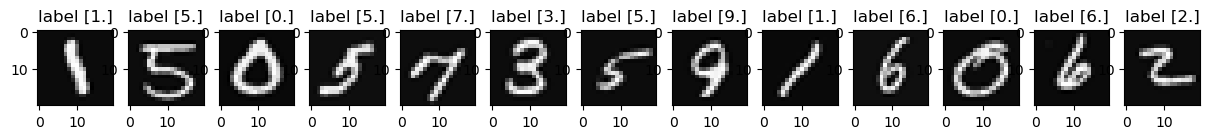

In [5]:
plt.figure(figsize=(15,8))
for i in range(13):
    c = random.randint(X.shape[0])
    a = X[c,1:].reshape((20, 20))
    a=np.transpose(a)
    plt.subplot(1,13,i+1)
    plt.title('label '+ str(y[c]))
    plt.imshow(a,cmap='gray')

# Partie 1, régression logistique
Dans cette partie, nous aimerions utiliser la régression logistique pour classifier nos images

Rappelons que la régression logistique nous donne la probabilité d'appartenance (oui ou non) à la classe 1 (elle permet une classification binaire).

Pour étendre la régression logistique à une multi-classification, nous allons utiliser une stratégie 1 contre tous.

Nous paramètres $\theta$ seront donc une matrice avec un nombre de lignes égale au nombre de classes, et avec un nombre de colones égale au nombre decaractéristiques (chaque ligne de la matrice $\theta$ correspond aux paramètres d'un classifieur.

In [6]:
def Sigmoid(z):
    return 1 / (1 + np.exp(-z));

In [7]:
def computeCostReg(X, y, theta, lambda_):
    pred=np.dot(X,theta)
    y_pred=Sigmoid(pred)
    eps = 1e-15
    y_Pred = np.clip((y_pred), eps, 1 - eps)
    cost=-(y*np.log(y_pred)+(1-y)*np.log(1-y_pred))
    J= np.mean(cost)-(lambda_/ (2 * X.shape[0])*(theta[1:] ** 2).sum(axis=0))
    return J

In [8]:
#descent du gradient avec regularization ou lambda est le paramétre de regularization
def get_deriv(X, y, theta):
    pred=Sigmoid(np.dot(X,theta))-y
    A=np.transpose(X)
    deriv=np.dot(A,pred)
    return deriv/(X.shape[0])
def lrCostFunction(X, y, initial_theta, alpha, MaxIter,lambda_,early_stopping=False):
    # dans cette fonction vous devez appliquer la regression logistique avec tout ce que ceci implique
    # calcul du coût, minimisation du coût avec descente du gradient, et retour des paramètres theta pour une classe
    cost_history=[]
    epsilon = 1e-9
    theta = np.array(initial_theta, copy=True)
    for i in range(0,MaxIter):
        deriv=get_deriv(X, y, theta) 
        # theta zero n'est pas affecter par la regularization 
        theta[0] = theta[0] - alpha * deriv[0]
        #mettre a jour le reste des theta en prennant en consideration le terme de regularization.
        #en utilisant la formule du cours
        theta[1:] = theta[1:] * (1 - lambda_ * alpha / X.shape[0]) - alpha * deriv[1:]
        cost_history.append(computeCostReg(X, y, theta,lambda_))
        #on s'arrete si le changement du cout entre iteration est trés petit 
        if early_stopping and i > 1 and (cost_history[-2] - cost_history[-1]) < epsilon: 
            break
    return theta.T,cost_history
    



In [9]:
def predictOneVsAll (all_theta, X):
    # ici en utilisant les paramètres calculés par la régression logisitique, 
    # nous aiemrions retourner les etiquettes predites
    
    # Ici chaque classifieur retournera une de probabilité, il faudra choisir la probabilité maximale 
    # de tous les classifieurs d'une exemple donné
    # répeter pour tous les exmemples
    
    #calcule de valeur pour les theta de tout les classificateur 
    Z=X @ all_theta.T
    #application du sigmoid et selection de la classe avec la plus grande proba 
    y_pred = np.argmax(Sigmoid(Z), axis=1)
    
    #on remarque que les label sont des reel donc avant de retorner les resultats on fait la corespondance entre les valeurs
    #predite et les label
    return classes[y_pred.reshape(-1,1)]

In [10]:
classes= np.unique(y)
number_classes=classes.shape[0]
all_theta = np.zeros((number_classes, X.shape[1]));
all_theta.shape

(10, 401)

In [11]:
MaxIter= 5000
lambda_= 0.1
alpha = 0.01

# initial_theta pour chaque classifieur
initial_theta=np.zeros((X.shape[1], 1));
costs=[]
for i in range (number_classes):
     # appel pour chaque classifieur
    theta,cost = lrCostFunction(X,(y==classes[i]).astype(int),initial_theta,alpha, MaxIter,lambda_);
    all_theta[i,:]=theta
    costs.append(cost)

In [12]:
y_pred = predictOneVsAll(all_theta, X);

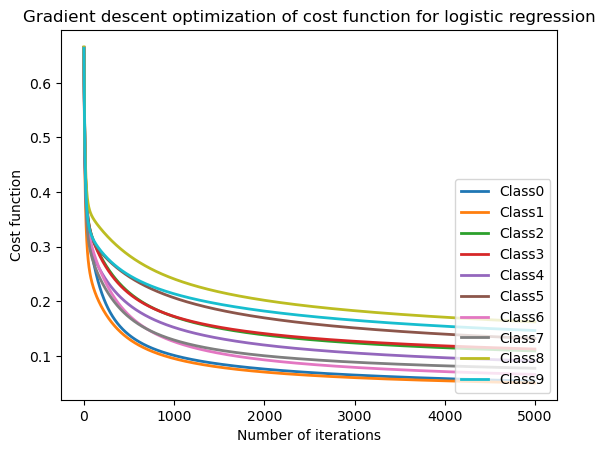

In [13]:
plt.figure()
lw = 2 # précisé l'épesseur des graphes 
for i in range (0,10): 
    #tracer la courbe de la classe i 
    plt.plot(range(len(costs[i])), costs[i],lw=lw, label='Class'+str(i))
plt.xlabel("Number of iterations")
plt.ylabel("Cost function")
plt.title("Gradient descent optimization of cost function for logistic regression")
plt.legend(loc="lower right")
plt.show()

# Qualité du classifieur RL

Prédire des valeurs de y

Ici il serait interessant de calculer la précision de notre classifieur

Essayons de calculer ça avec 

moyenne(y==y-pred) * 100

Ceci donnera un pourcentage de precision

In [14]:
precision = np.mean(y==y_pred)*100
precision


88.5

# Partie 2: Réseaux de neurones
Pour cette partie, nous choisissons une réseau simple:

- une couche d'entrée avec 400 noeuds (20 x 20 pixels) + le biais
- une couche cachée avec 25 noeuds
- une couche de sortie avec 10 noeuds (nombre de classes)

In [15]:
# poids de la couche 1
W1 = np.genfromtxt('W1.csv', delimiter=',', dtype=float)
W1.shape


(25, 401)

In [16]:
# poids de la couche 2
W2 = np.genfromtxt('W2.csv', delimiter=',', dtype=float)
W2.shape

(10, 26)

In [17]:
input_layer_size  = 400;  
hidden_layer_size = 25;   
num_labels = 10;

**Prédiction**

Appliquer une propagation en avant en utilisant les paramètres données pour prédir les classes de l'ensemble d'apprentissage.



In [18]:
def predict (W1, W2, X):
    
    # appliquer une propagation en avant
    # !--- n'oubliez pas d'appliquer la sigmoid à chaque couche afin d'avoir les probabilités ---!
    
    # prédire la classe en choisissant la probabilité maximale parmi les 10 noeuds de sortie
    #resultas de la premiére couche 
    h1_output = Sigmoid(X @ W1.T)
    #on rajoute le bias
    intercept = np.ones((X.shape[0],1))
    h2_input = np.column_stack((intercept, h1_output))
    # resultas de la deuxiéme couche 
    h2_output = Sigmoid(h2_input @ W2.T)
    #selection de la classe avec la plus grande proba 
    y_pred = np.argmax(h2_output, axis=1).reshape(-1, 1)
    
    # on a remarqué que sans changé les classe prédite la précision est de 12%
    #et on a retrouvé que la cause est que le dataset MNIST de base c'est le 0 qui a comme label  10 
    # donc aprés décalage de touts les résultats prédit on ontient une bonne précision 
    y_pred = y_pred + 1
    y_pred[y_pred==10] = 0
    return y_pred

In [19]:
# calcul de precision = nombre de valeurs bien prédites (ici sur toute la base X)
y_pred=predict(W1,W2,X)
precision = np.mean(y==y_pred)*100
precision

97.52

# Vérification de l'implementation
Comparer vos algorithmes à ceux de scikitlearn

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score


# Create a LogisticRegression model with default settings
model = LogisticRegression(multi_class='ovr',max_iter=1000)

# Train the model on the training set
model.fit(X[:, 1:], y.squeeze())

# Make predictions on the test set
y_pred = model.predict(X[:, 1:])

# Compute the precision of the predictions
precision = precision_score(y.squeeze(), y_pred, average='macro')

print("Precision: {:.2f}".format(precision*100))


Precision: 94.45


# Renforcement d'apprentissage
Mettre ici toute idée qui pourrait renforcer votre apprentissage

###  Standarisation des données de l'apprentissage

In [21]:
#la standarization ne concerne pas la premiére colonne de 1 
X_standardized = np.ones_like(X)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X[:,1:])
X_standardized[:,1:] = scaler.transform(X[:,1:])


In [22]:
MaxIter= 5000
lambda_= 0.1
alpha = 0.01

# initial_theta pour chaque classifieur
initial_theta=np.zeros((X.shape[1], 1));
costs=[]
for i in range (number_classes):
     # appel pour chaque classifieur
    theta,cost = lrCostFunction(X_standardized,(y==classes[i]).astype(int),initial_theta,alpha, MaxIter,lambda_);
    all_theta[i,:]=theta
    costs.append(cost)

In [23]:
y_pred = predictOneVsAll(all_theta, X_standardized);

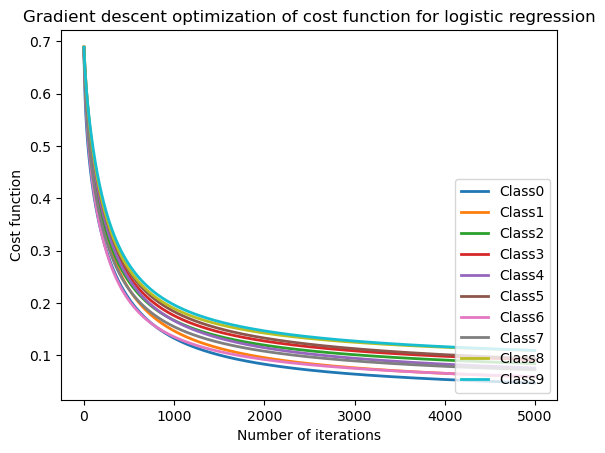

In [24]:
plt.figure()
lw = 2 # précisé l'épesseur des graphes 
for i in range (0,10): 
    #tracer la courbe de la classe i 
    plt.plot(range(len(costs[i])), costs[i],lw=lw, label='Class'+str(i))
plt.xlabel("Number of iterations")
plt.ylabel("Cost function")
plt.title("Gradient descent optimization of cost function for logistic regression")
plt.legend(loc="lower right")
plt.show()

In [25]:
precision = np.mean(y==y_pred)*100
precision

91.75999999999999

**on remarque une meilleure précision aprés l'application de la standarisation**

# Consignes

Le travail est à remettre par groupe de 4 au maximum [1..4].

Le délai est le vendredi 22 Avril 2022 à 22h


In [26]:
# bonne chance